# Test validity partial step 4 : $P(B_f | ...) \propto \eta^t \ \left(\bold{C}_{\rm approx}^{1/2}(\bold{N_{c}}^{-1} + \bold{C}_{\rm approx}^{-1}) \bold{C}_{\rm approx}^{1/2} \right)^{-1} \ \eta$

In [1]:
import os, sys, time
import numpy as np
import matplotlib.pyplot as plt
import jax
from jax import random, dtypes
import jax.numpy as jnp
import jax.scipy as jsp
import jax_healpy as jhp
import scipy
import healpy as hp
import astropy.io.fits as fits
import camb
import numpyro
import numpyro.distributions as dist

import micmac as micmac

In [2]:
sys.path.append(os.path.dirname(os.path.abspath('')))
sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath('')))+'/tutorials/')
from func_tools_for_tests import *
from get_freq_maps_SO_64 import *
# freq_maps is defined there

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


Shape for input frequency maps : (6, 2, 49152)
Shape for input cmb maps : (6, 2, 49152)


In [3]:
instrument

,frequency,depth_p,depth_i,fwhm,f_sky,status,reference,type,note,experiment
0,27.0,49.5,35.0,91.0,0.1,forecast,Journal of Cosmology and Astroparticle Physics...,ground,depth_p is simply depth_i * sqrt(2),SO_SAT
1,39.0,29.7,21.0,63.0,0.1,forecast,Journal of Cosmology and Astroparticle Physics...,ground,depth_p is simply depth_i * sqrt(2),SO_SAT
2,93.0,3.7,2.6,30.0,0.1,forecast,Journal of Cosmology and Astroparticle Physics...,ground,depth_p is simply depth_i * sqrt(2),SO_SAT
3,145.0,4.7,3.3,17.0,0.1,forecast,Journal of Cosmology and Astroparticle Physics...,ground,depth_p is simply depth_i * sqrt(2),SO_SAT
4,225.0,8.9,6.3,11.0,0.1,forecast,Journal of Cosmology and Astroparticle Physics...,ground,depth_p is simply depth_i * sqrt(2),SO_SAT
5,280.0,22.6,16.0,9.0,0.1,forecast,Journal of Cosmology and Astroparticle Physics...,ground,depth_p is simply depth_i * sqrt(2),SO_SAT


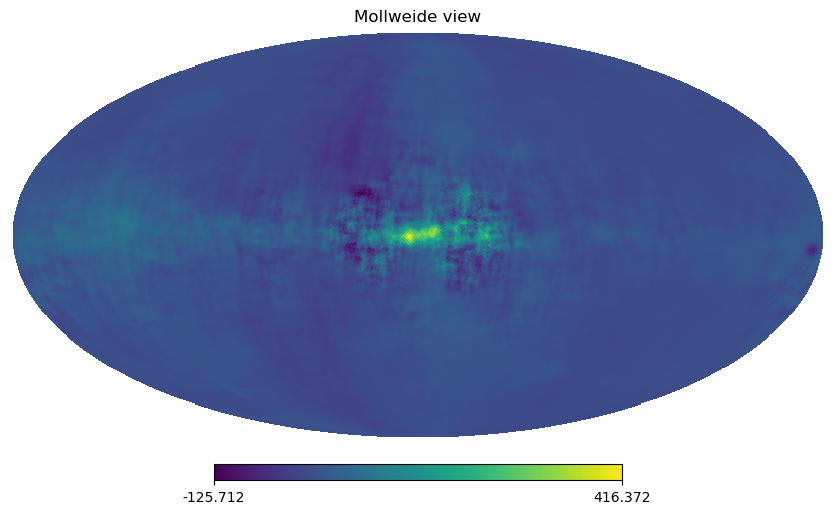

In [4]:
hp.mollview(freq_maps[0,0]) # Freq, nstokes, npix

In [5]:
# working_directory_path = os.path.abspath('') + '/'
working_directory_path = '/Users/mag/Documents/PHD1Y/Space_Work/Pixel_non_P2D/MICMAC/test_playground/validation_chain_v3/'
directory_save_file = working_directory_path + 'save_directory/'
directory_toml_file = working_directory_path + 'toml_params/'

path_toml_file = directory_toml_file + 'test_full_chain_v1a.toml'
path_toml_file = directory_toml_file + 'test_full_chain_v1c.toml'
# path_toml_file = directory_toml_file + 'test_classical_chain_v1a.toml'


In [6]:
MICMAC_sampler_obj = micmac.create_MICMAC_sampler_from_toml_file(path_toml_file)

In [7]:
reduction_noise = 1
# MICMAC_sampler_obj.r_true = 1

In [8]:
freq_inverse_noise = micmac.get_noise_covar(instrument['depth_p']/reduction_noise, MICMAC_sampler_obj.nside)

In [9]:
instrument = get_instrument(instr_name)

noise_bool = True
# noise_bool = False

instrument['depth_p'] /= reduction_noise
# get input freq maps
np.random.seed(noise_seed)
# freq_maps = get_observation(instrument, model, nside=NSIDE, noise=noise)[:, 1:, :]   # keep only Q and U
freq_maps_fgs = get_observation(instrument, fgs_model, nside=MICMAC_sampler_obj.nside, noise=noise_bool)[:, 1:, :]   # keep only Q and U


In [10]:
indices_polar = np.array([1,2,4])
partial_indices_polar = indices_polar[:MICMAC_sampler_obj.nstokes]

In [11]:
init_mixing_matrix_obj = micmac.InitMixingMatrix(np.array(instrument['frequency']), MICMAC_sampler_obj.number_components, pos_special_freqs=[0,-1])
init_params = init_mixing_matrix_obj.init_params()

mixing_matrix_obj = micmac.MixingMatrix(instrument['frequency'], MICMAC_sampler_obj.number_components, init_params, pos_special_freqs=[0,-1])

mixing_matrix_sampled = mixing_matrix_obj.get_B()

BtinvNB = micmac.get_inv_BtinvNB(freq_inverse_noise, mixing_matrix_sampled)
BtinvN_sqrt = micmac.get_BtinvN(scipy.linalg.sqrtm(freq_inverse_noise), mixing_matrix_sampled)
BtinvN = micmac.get_BtinvN(freq_inverse_noise, mixing_matrix_sampled)

In [12]:
# input_freq_maps, theoretical_red_cov_r0_total, theoretical_red_cov_r1_tensor = MICMAC_sampler_obj.generate_input_freq_maps_from_fgs(freq_maps_fgs, return_only_freq_maps=False)
input_freq_maps, input_cmb_maps, theoretical_red_cov_r0_total, theoretical_red_cov_r1_tensor = MICMAC_sampler_obj.generate_input_freq_maps_from_fgs(freq_maps_fgs, return_only_freq_maps=False)

theoretical_r0_total = micmac.get_c_ells_from_red_covariance_matrix(theoretical_red_cov_r0_total)

# true_cmb_specra = micmac.get_c_ells_from_red_covariance_matrix(theoretical_red_cov_r0_total + MICMAC_sampler_obj.r_true*theoretical_red_cov_r1_tensor)
# true_cmb_specra_extended = np.zeros((6,MICMAC_sampler_obj.lmax+1))
# true_cmb_specra_extended[indices_polar,MICMAC_sampler_obj.lmin:] = true_cmb_specra

# input_cmb_maps_alt = hp.synfast(true_cmb_specra_extended, nside=MICMAC_sampler_obj.nside, new=True, lmax=MICMAC_sampler_obj.lmax)[1:,...]

# input_cmb_maps = np.repeat(input_cmb_maps_alt.ravel(order='F'), MICMAC_sampler_obj.number_frequencies).reshape((MICMAC_sampler_obj.number_frequencies,MICMAC_sampler_obj.nstokes,MICMAC_sampler_obj.npix),order='F')

# input_freq_maps = input_cmb_maps + freq_maps_fgs

Calculating spectra from CAMB !
Calculating spectra from CAMB !


In [13]:
s_cML = micmac.get_Wd(freq_inverse_noise, mixing_matrix_sampled, input_freq_maps, jax_use=False)[0, :, :]

In [14]:
red_cov_matrix_sample = theoretical_red_cov_r0_total + MICMAC_sampler_obj.r_true * theoretical_red_cov_r1_tensor

red_cov_approx_matrix = np.copy(theoretical_red_cov_r0_total)
c_ell_approx = micmac.get_c_ells_from_red_covariance_matrix(red_cov_approx_matrix)

In [15]:
jax_key_PNRG = jax.random.PRNGKey(MICMAC_sampler_obj.seed+1)
map_random_x = jnp.empty(0)
map_random_y = jnp.empty(0)
# eta_maps = MAC_obj.get_sampling_eta_v2(red_cov_approx_matrix, BtinvNB, BtinvN_sqrt, jax_key_PNRG, map_random_x=map_random_x, map_random_y=map_random_y, suppress_low_modes=True)
eta_maps = MICMAC_sampler_obj.get_sampling_eta_v2(red_cov_approx_matrix, BtinvNB, BtinvN_sqrt, jax_key_PNRG, map_random_x=map_random_x, map_random_y=map_random_y, suppress_low_modes=True)

Recalculating x !
Recalculating y !


In [16]:
number_correl_to_plot = int(np.ceil(MICMAC_sampler_obj.nstokes**2/2) + np.floor(MICMAC_sampler_obj.nstokes/2))

if MICMAC_sampler_obj.nstokes == 3:
    number_subplots_convention = 421
    figsize = (10,10)
    figsize_big = (12,12)
    position_legend = int(number_correl_to_plot/2)-1
    bbox_to_anchor=(2.2, 1)
elif MICMAC_sampler_obj.nstokes == 2:
    number_subplots_convention = 131
    figsize = (14,6)
    figsize_big = figsize
    position_legend = number_correl_to_plot-1
    bbox_to_anchor=(1, 1)
else:
    number_subplots_convention = 111
    figsize = (10,10)
    figsize_big = (10,10)
    position_legend = int(number_correl_to_plot/2)-1
    bbox_to_anchor=(2.2, 1)

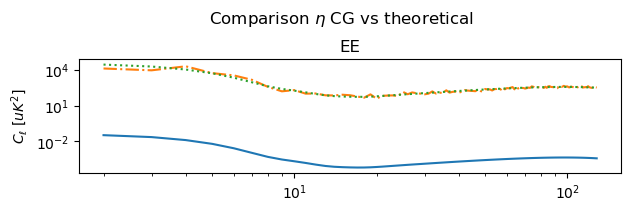

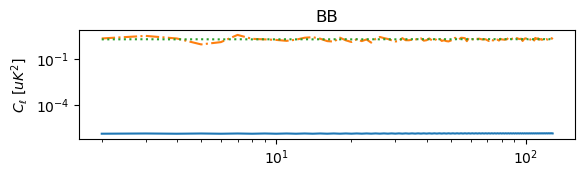

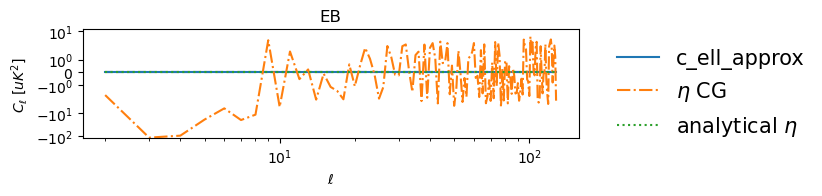

In [17]:
red_cov_approx_matrix_sqrt = micmac.get_sqrt_reduced_matrix_from_matrix(red_cov_approx_matrix)

covariance_noise = np.zeros_like(c_ell_approx)

cl_noise = BtinvNB[0,0]*hp.nside2resol(MICMAC_sampler_obj.nside)**2
_cl_noise_harm = micmac.get_Cl_noise(np.array(instrument['depth_p']), mixing_matrix_sampled, MICMAC_sampler_obj.lmax)[0,0,MICMAC_sampler_obj.lmin:]
red_cl_noise_harm = micmac.get_reduced_matrix_from_c_ell(np.array([_cl_noise_harm,_cl_noise_harm,np.zeros_like(_cl_noise_harm)]))

# analytical_eta_term_cov = np.einsum('lij,ljk,lkm->lim', red_cov_approx_matrix_sqrt, np.linalg.pinv(red_cov_approx_matrix) + eye_Stokes_personalized/BtinvNB[0,0], red_cov_approx_matrix_sqrt)
analytical_eta_term_cov = np.einsum('lij,ljk,lkm->lim', red_cov_approx_matrix_sqrt, np.linalg.pinv(red_cov_approx_matrix) + np.linalg.pinv(red_cl_noise_harm), red_cov_approx_matrix_sqrt)

# analytical_eta_term = np.zeros_like(c_ell_approx)
analytical_eta_term = micmac.get_c_ells_from_red_covariance_matrix(analytical_eta_term_cov)#[:,lmin:]


eta_maps_extended = np.vstack([np.zeros_like(eta_maps[0]), eta_maps])
c_ells_eta = hp.anafast(eta_maps_extended, lmax=MICMAC_sampler_obj.lmax, iter=MICMAC_sampler_obj.n_iter)[indices_polar,MICMAC_sampler_obj.lmin:]

plt.figure(figsize=(7,5))
plt.suptitle(r"Comparison $\eta$ CG vs theoretical")

list_correl = ['EE', 'BB', 'EB']
ell_arange = np.arange(MICMAC_sampler_obj.lmax+1-MICMAC_sampler_obj.lmin) + MICMAC_sampler_obj.lmin
for j in range(number_correl_to_plot):
    ax = plt.subplot(311+j)
    plt.title(list_correl[j])
    
    plt.plot([ell_arange[0], ell_arange[-1]], [0,0], '--', color='black')
    
    plt.plot(ell_arange, c_ell_approx[j,:], label='c_ell_approx')
    plt.plot(ell_arange, c_ells_eta[j,:], '-.', label=r"$\eta$ CG")
    
    plt.plot(ell_arange, analytical_eta_term[j,:], ':', label=r"analytical $\eta$")

    if MICMAC_sampler_obj.nstokes == 3 and j < number_correl_to_plot-2:
        plt.xticks(color='w')

    if j <= MICMAC_sampler_obj.nstokes-1:
        plt.loglog()
        # plt.ylim(ymin=noise_level/10.)
    else:
        plt.xscale('log')
        plt.yscale('symlog')
    # plt.legend()
    if j == position_legend:
        plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left", prop={'size': 15}, frameon=False)
    
    plt.ylabel("$C_\ell$ [$uK^2$]")
    if j == number_correl_to_plot-1:
        plt.xlabel(r"$\ell$")


    plt.show()

In [18]:
PRNGKey = random.PRNGKey(0)
wiener_filter_term = MICMAC_sampler_obj.solve_generalized_wiener_filter_term(s_cML, red_cov_matrix_sample, BtinvNB, initial_guess=jnp.empty(0))

map_random_realization_xi = jnp.empty(0)
map_random_realization_chi = jnp.empty(0)
fluctuation_maps = MICMAC_sampler_obj.get_fluctuating_term_maps(red_cov_matrix_sample, BtinvNB, BtinvN_sqrt, PRNGKey+2, map_random_realization_xi=map_random_realization_xi, map_random_realization_chi=map_random_realization_chi, initial_guess=jnp.empty(0))

s_c_sample = wiener_filter_term + fluctuation_maps

CG-Python-0 WF finished in  None iterations !!
Recalculating xi !
Recalculating chi !
CG-Python-0 Fluct finished in  None iterations !!


In [19]:
nstokes = MICMAC_sampler_obj.nstokes
lmin = MICMAC_sampler_obj.lmin
lmax = MICMAC_sampler_obj.lmax
nside = MICMAC_sampler_obj.nside
n_iter = MICMAC_sampler_obj.n_iter

In [20]:
_cl_noise_harm = micmac.get_Cl_noise(np.array(instrument['depth_p']), mixing_matrix_sampled, lmax)[0,0,lmin:]
red_cl_noise_harm = micmac.get_reduced_matrix_from_c_ell(np.array([_cl_noise_harm,_cl_noise_harm,np.zeros_like(_cl_noise_harm)]))
cl_noise_harm = micmac.get_c_ells_from_red_covariance_matrix(red_cl_noise_harm)

/Users/mag/miniconda3/envs/non_param_silver/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: All values for SymLogScale are below linthresh, making it effectively linear. You likely should lower the value of linthresh. 
  fig.canvas.print_figure(bytes_io, **kw)


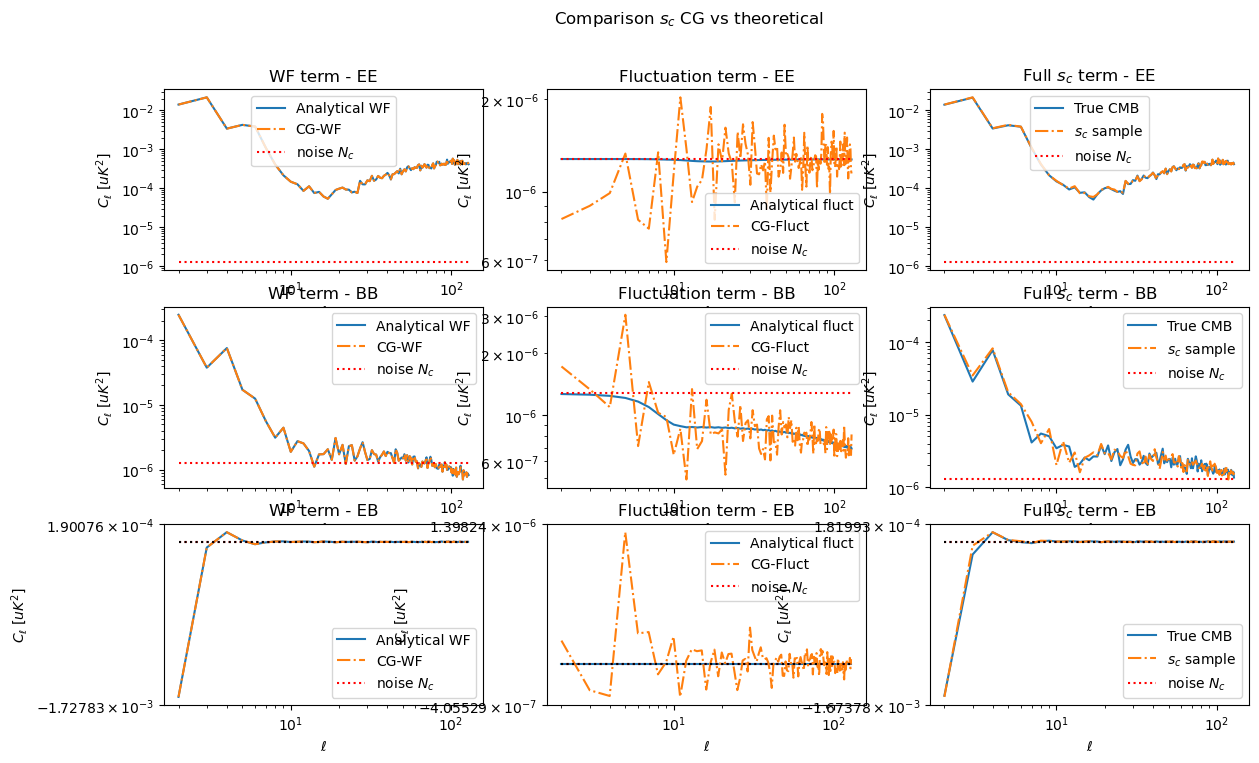

In [21]:
list_correl = ['EE', 'BB', 'EB']

map_true_CMB_ext = np.vstack([np.zeros_like(input_cmb_maps[0,0,...]), input_cmb_maps[0]])
c_ell_true_CMB = hp.anafast(map_true_CMB_ext, lmax=lmax, iter=n_iter)[indices_polar, lmin:]

covariance_noise = np.zeros_like(c_ell_true_CMB)

# analytical_WF_harm = np.linalg.pinv(np.linalg.pinv(red_cov_matrix_sample) + np.eye(nstokes)/BtinvNB[0,0])
# # analytical_WF_harm = np.linalg.pinv(np.linalg.pinv(red_cov_matrix) + eye_Stokes_only_B/BtinvNB[0,0])
# analytical_WF_map = micmac.maps_x_reduced_matrix_generalized_sqrt_sqrt(s_cML/BtinvNB[0,0], analytical_WF_harm, lmin=lmin, n_iter=n_iter)
analytical_WF_harm = np.linalg.pinv(np.linalg.pinv(red_cov_matrix_sample) + np.linalg.pinv(red_cl_noise_harm))
# analytical_WF_harm = np.linalg.pinv(np.linalg.pinv(red_cov_matrix) + eye_Stokes_only_B/BtinvNB[0,0])
analytical_WF_map = micmac.maps_x_reduced_matrix_generalized_sqrt_sqrt(s_cML/BtinvNB[0,0]/hp.nside2resol(MICMAC_sampler_obj.nside)**2,
                                                                        analytical_WF_harm, lmin=lmin, n_iter=n_iter)


analytical_WF_map_ext = np.vstack([np.zeros_like(analytical_WF_map[0]),analytical_WF_map])
analytical_WF_cells = hp.anafast(analytical_WF_map_ext, lmax=lmax, iter=n_iter)[indices_polar,lmin:]
analytical_fluct_c_ell = micmac.get_c_ells_from_red_covariance_matrix(analytical_WF_harm.copy())#[indices_polar,lmin:]

s_c_WF_maps_extended = np.vstack([np.zeros_like(wiener_filter_term[0,...]), wiener_filter_term])
c_ells_s_c_WF = hp.anafast(s_c_WF_maps_extended, lmax=lmax, iter=n_iter)[indices_polar,lmin:]

s_c_fluct_maps_extended = np.vstack([np.zeros_like(fluctuation_maps[0,...]), fluctuation_maps])
c_ells_s_c_fluct = hp.anafast(s_c_fluct_maps_extended, lmax=lmax, iter=n_iter)[indices_polar,lmin:]

s_c_recovered_ext = np.vstack([np.zeros_like(s_c_sample[0]),s_c_sample])
c_ells_s_c = hp.anafast(s_c_recovered_ext, lmax=lmax, iter=n_iter)[indices_polar,lmin:]

plt.figure(figsize=(14,8))
plt.suptitle(r"Comparison $s_c$ CG vs theoretical")

for j in range(number_correl_to_plot):
    plt.subplot(331+3*j)
    plt.plot(np.arange(c_ells_s_c_WF.shape[-1])+lmin, analytical_WF_cells[j,:], label='Analytical WF')
    plt.plot(np.arange(c_ells_s_c_WF.shape[-1])+lmin, c_ells_s_c_WF[j,:], '-.', label='CG-WF')
    plt.plot(np.arange(c_ells_s_c_fluct.shape[-1])+MICMAC_sampler_obj.lmin, cl_noise_harm[j,:], 'r:', label='noise $N_c$')
    if j <= nstokes-1:
        plt.loglog()
    else:
        plt.xscale('log')
        plt.yscale('symlog')
        plt.plot([lmin,lmax+1], [0,0], 'k:')
    plt.title('WF term - {}'.format(list_correl[j]))
    plt.ylabel("$C_\ell$ [$uK^2$]")
    plt.xlabel(r"$\ell$")
    plt.legend()

    plt.subplot(332+3*j)
    plt.plot(np.arange(c_ells_s_c_fluct.shape[-1])+lmin, analytical_fluct_c_ell[j,:], label='Analytical fluct')
    plt.plot(np.arange(c_ells_s_c_fluct.shape[-1])+lmin, c_ells_s_c_fluct[j,:], '-.', label='CG-Fluct')
    plt.plot(np.arange(c_ells_s_c_fluct.shape[-1])+MICMAC_sampler_obj.lmin, cl_noise_harm[j,:], 'r:', label='noise $N_c$')

    if j <= nstokes-1:
        plt.loglog()
    else:
        plt.xscale('log')
        plt.yscale('symlog')
        plt.plot([lmin,lmax+1], [0,0], 'k:')
    plt.title('Fluctuation term - {}'.format(list_correl[j]))
    plt.ylabel("$C_\ell$ [$uK^2$]")
    plt.xlabel(r"$\ell$")
    plt.legend()
    
    plt.subplot(333+3*j)
    plt.plot(np.arange(c_ells_s_c_WF.shape[-1])+lmin, c_ell_true_CMB[j,:], label='True CMB')
    plt.plot(np.arange(c_ells_s_c_fluct.shape[-1])+lmin, c_ells_s_c[j,:], '-.', label='$s_c$ sample')
    plt.plot(np.arange(c_ells_s_c_fluct.shape[-1])+MICMAC_sampler_obj.lmin, cl_noise_harm[j,:], 'r:', label='noise $N_c$')

    if j <= nstokes-1:
        plt.loglog()
        plt.plot([lmin,lmax+1], [0,0], 'k:')
    else:
        plt.xscale('log')
        plt.yscale('symlog')
        plt.plot([lmin,lmax+1], [0,0], 'k:')
    plt.title('Full $s_c$ term - {}'.format(list_correl[j]))
    plt.ylabel("$C_\ell$ [$uK^2$]")
    
    plt.xlabel(r"$\ell$")
    plt.legend()


plt.show()

In [22]:
def get_conditional_proba_first_part_JAX(complete_mixing_matrix, _input_freq_maps, suppress_low_modes=True):
    """ Get conditional probability of spectral likelihood by sampling

        The associated conditional probability is given by : 
        - d^t N^{-1} B (B^t N^{-1} B)^{-1} B^t N^{-1} d
    """

    # Building the spectral_likelihood : - (d - B_c s_c)^t N^{-1} B_f (B_f^t N^{-1} B_f)^{-1} B_f^t N^{-1} (d - B_c s_c)

    BtinvNB = micmac.get_inv_BtinvNB(MICMAC_sampler_obj.freq_inverse_noise, complete_mixing_matrix, jax_use=True)#*jhp.nside2resol(MICMAC_sampler_obj.nside)**2
    BtinvN = micmac.get_BtinvN(MICMAC_sampler_obj.freq_inverse_noise, complete_mixing_matrix, jax_use=True)#/jhp.nside2resol(MICMAC_sampler_obj.nside)**2

    full_data_without_CMB_with_noise = jnp.einsum('cf,fsp->csp', BtinvN, _input_freq_maps)
    if suppress_low_modes:
        covariance_unity = jnp.zeros((MICMAC_sampler_obj.lmax+1-MICMAC_sampler_obj.lmin,MICMAC_sampler_obj.nstokes,MICMAC_sampler_obj.nstokes))
        # covariance_unity = covariance_unity.at[lmin:,...].set(jnp.eye(nstokes))
        covariance_unity = covariance_unity.at[:,...].set(jnp.eye(MICMAC_sampler_obj.nstokes))
        for i in range(MICMAC_sampler_obj.number_components-1):
            full_data_without_CMB_with_noise = full_data_without_CMB_with_noise.at[i].set(
                micmac.maps_x_reduced_matrix_generalized_sqrt_sqrt_JAX_compatible(jnp.copy(full_data_without_CMB_with_noise[i]), 
                                                                                  covariance_unity, nside=MICMAC_sampler_obj.nside, lmin=MICMAC_sampler_obj.lmin, n_iter=MICMAC_sampler_obj.n_iter))

    first_term_complete = jnp.einsum('psc,cm,msp', full_data_without_CMB_with_noise.T, BtinvNB, full_data_without_CMB_with_noise)
    return -(-first_term_complete + 0)/2.

def get_conditional_proba_second_part_JAX(complete_mixing_matrix, _input_freq_maps, red_cov_matrix):

    s_c_ML = micmac.get_Wd(MICMAC_sampler_obj.freq_inverse_noise, complete_mixing_matrix, _input_freq_maps, jax_use=True)[0, :, :]#/jhp.nside2resol(MICMAC_sampler_obj.nside)**2

    # new_BtinvNB = micmac.get_inv_BtinvNB(MICMAC_sampler_obj.freq_inverse_noise, complete_mixing_matrix, jax_use=True)
    # cl_noise_harmonic = new_BtinvNB[0,0]*jhp.nside2resol(MICMAC_sampler_obj.nside)**2
    cl_noise_harmonic = micmac.get_Cl_noise_JAX(np.array(instrument['depth_p']), complete_mixing_matrix, MICMAC_sampler_obj.lmax)[0,0,MICMAC_sampler_obj.lmin:]
    red_cl_noise_harmonic = micmac.get_reduced_matrix_from_c_ell_jax(jnp.array([cl_noise_harmonic,cl_noise_harmonic,jnp.zeros_like(cl_noise_harmonic)]))

    harmonic_operator = jnp.linalg.pinv(red_cov_matrix + red_cl_noise_harmonic)
    first_term = micmac.maps_x_reduced_matrix_generalized_sqrt_sqrt_JAX_compatible(s_c_ML, harmonic_operator, nside=MICMAC_sampler_obj.nside, lmin=MICMAC_sampler_obj.lmin, n_iter=MICMAC_sampler_obj.n_iter)

    return -jnp.einsum('sp,sp', s_c_ML, first_term)/2.

def get_conditional_proba_third_part_JAX(complete_mixing_matrix, red_cov_matrix):
    """ Get conditional probability of perturbation likelihood by computing it directly in harmonic space

        The associated conditional probability is given by :
    """

    # new_BtinvNB = micmac.get_inv_BtinvNB(MICMAC_sampler_obj.freq_inverse_noise, complete_mixing_matrix, jax_use=True)
    # cl_noise_harmonic = new_BtinvNB[0,0]*jhp.nside2resol(MICMAC_sampler_obj.nside)**2
    # _cl_noise_harm = new_BtinvNB[0,0]*jhp.nside2resol(self.nside)**2
    cl_noise_harmonic = micmac.get_Cl_noise_JAX(jnp.array(instrument['depth_p']), complete_mixing_matrix, MICMAC_sampler_obj.lmax)[0,0,MICMAC_sampler_obj.lmin:]
    red_cl_noise_harm_CMB = micmac.get_reduced_matrix_from_c_ell_jax(jnp.array([cl_noise_harmonic,cl_noise_harmonic,jnp.zeros_like(cl_noise_harmonic)]))


    red_operator_term = red_cov_matrix + red_cl_noise_harm_CMB

    log_det_correction = ( (2*jnp.arange(MICMAC_sampler_obj.lmin, MICMAC_sampler_obj.lmax+1) +1) * jnp.log(jnp.linalg.det(red_operator_term)) ).sum()

    return -log_det_correction/2.

def get_conditional_proba_fourth_part_JAX(complete_mixing_matrix, red_cov_approx_matrix):
    """ Get conditional probability of perturbation likelihood by computing it directly in harmonic space

        The associated conditional probability is given by :
    """

    # new_BtinvNB = micmac.get_inv_BtinvNB(MICMAC_sampler_obj.freq_inverse_noise, complete_mixing_matrix, jax_use=True)
    # cl_noise_harmonic = new_BtinvNB[0,0]*jhp.nside2resol(MICMAC_sampler_obj.nside)**2
    cl_noise_harmonic = micmac.get_Cl_noise_JAX(jnp.array(instrument['depth_p']), complete_mixing_matrix, MICMAC_sampler_obj.lmax)[0,0,MICMAC_sampler_obj.lmin:]
    red_cl_noise_harm_CMB = micmac.get_reduced_matrix_from_c_ell_jax(jnp.array([cl_noise_harmonic,cl_noise_harmonic,jnp.zeros_like(cl_noise_harmonic)]))

    red_operator_term = jnp.linalg.pinv(red_cov_approx_matrix + red_cl_noise_harm_CMB)

    log_det_correction = ( (2*jnp.arange(MICMAC_sampler_obj.lmin, MICMAC_sampler_obj.lmax+1) +1) * jnp.log(jnp.linalg.det(red_operator_term)) ).sum()

    return -log_det_correction/2.


def get_alternative_sampling_r_B_f(all_params, _input_freq_maps, red_cov_approx_matrix):
    """ Get alternative sampling B_f with proper marginalization over s_c
    """

    new_params_mixing_matrix = all_params[:-1]
    r_value = all_params[-1]

    params_mixing_matrix = jnp.copy(new_params_mixing_matrix)
    red_cov_matrix = theoretical_red_cov_r0_total + r_value * theoretical_red_cov_r1_tensor

    # new_mixing_matrix = create_mixing_matrix_jax(params_mixing_matrix, self.number_components, self.number_frequencies, pos_special_freqs=self.pos_special_freqs)
    MICMAC_sampler_obj._fake_mixing_matrix.update_params(params_mixing_matrix.reshape((MICMAC_sampler_obj.number_frequencies-jnp.size(MICMAC_sampler_obj.pos_special_freqs), MICMAC_sampler_obj.number_components-1),order='F'),jax_use=True)
    new_mixing_matrix = MICMAC_sampler_obj._fake_mixing_matrix.get_B(jax_use=True)
    
    factor_norm = jhp.nside2resol(MICMAC_sampler_obj.nside)**2
    # factor_norm = 1/MICMAC_sampler_obj.npix
    log_proba_first_term = get_conditional_proba_first_part_JAX(new_mixing_matrix, _input_freq_maps, suppress_low_modes=True)*factor_norm
    log_proba_second_term = get_conditional_proba_second_part_JAX(new_mixing_matrix, _input_freq_maps, red_cov_matrix)*factor_norm
    log_proba_third_term = get_conditional_proba_third_part_JAX(new_mixing_matrix, red_cov_matrix)
    log_proba_fourth_term = get_conditional_proba_fourth_part_JAX(new_mixing_matrix, red_cov_approx_matrix)

    return -(log_proba_first_term + log_proba_second_term + log_proba_third_term + log_proba_fourth_term)

def get_alternative_sampling_r_B_f_wo_corr(all_params, _input_freq_maps, red_cov_approx_matrix):
    """ Get alternative sampling B_f with proper marginalization over s_c
    """
    new_params_mixing_matrix = all_params[:-1]
    r_value = all_params[-1]

    params_mixing_matrix = jnp.copy(new_params_mixing_matrix)
    red_cov_matrix = theoretical_red_cov_r0_total + r_value * theoretical_red_cov_r1_tensor

    # new_mixing_matrix = create_mixing_matrix_jax(params_mixing_matrix, self.number_components, self.number_frequencies, pos_special_freqs=self.pos_special_freqs)
    MICMAC_sampler_obj._fake_mixing_matrix.update_params(params_mixing_matrix.reshape((MICMAC_sampler_obj.number_frequencies-jnp.size(MICMAC_sampler_obj.pos_special_freqs), MICMAC_sampler_obj.number_components-1),order='F'),jax_use=True)
    new_mixing_matrix = MICMAC_sampler_obj._fake_mixing_matrix.get_B(jax_use=True)
    
    factor_norm = jhp.nside2resol(MICMAC_sampler_obj.nside)**2
    # factor_norm = 1/MICMAC_sampler_obj.npix
    log_proba_first_term = get_conditional_proba_first_part_JAX(new_mixing_matrix, _input_freq_maps, suppress_low_modes=True)*factor_norm
    log_proba_second_term = get_conditional_proba_second_part_JAX(new_mixing_matrix, _input_freq_maps, red_cov_matrix)*factor_norm
    log_proba_third_term = get_conditional_proba_third_part_JAX(new_mixing_matrix, red_cov_matrix)
    # log_proba_fourth_term = get_conditional_proba_fourth_part_JAX(new_mixing_matrix, red_cov_approx_matrix)

    return -(log_proba_first_term + log_proba_second_term + log_proba_third_term) #+ log_proba_fourth_term

def get_alternative_sampling_r_B_f_only_corr(all_params, _input_freq_maps, red_cov_approx_matrix):
    """ Get alternative sampling B_f with proper marginalization over s_c
    """
    new_params_mixing_matrix = all_params[:-1]
    r_value = all_params[-1]

    params_mixing_matrix = jnp.copy(new_params_mixing_matrix)
    red_cov_matrix = theoretical_red_cov_r0_total + r_value * theoretical_red_cov_r1_tensor

    # new_mixing_matrix = create_mixing_matrix_jax(params_mixing_matrix, self.number_components, self.number_frequencies, pos_special_freqs=self.pos_special_freqs)
    MICMAC_sampler_obj._fake_mixing_matrix.update_params(params_mixing_matrix.reshape((MICMAC_sampler_obj.number_frequencies-jnp.size(MICMAC_sampler_obj.pos_special_freqs), MICMAC_sampler_obj.number_components-1),order='F'),jax_use=True)
    new_mixing_matrix = MICMAC_sampler_obj._fake_mixing_matrix.get_B(jax_use=True)
    
    # log_proba_first_term = get_conditional_proba_first_part_JAX(new_mixing_matrix, _input_freq_maps, suppress_low_modes=True)
    # log_proba_second_term = get_conditional_proba_second_part_JAX(new_mixing_matrix, _input_freq_maps, red_cov_matrix)
    # log_proba_third_term = get_conditional_proba_third_part_JAX(new_mixing_matrix, red_cov_matrix)
    log_proba_fourth_term = get_conditional_proba_fourth_part_JAX(new_mixing_matrix, red_cov_approx_matrix)

    return -log_proba_fourth_term

In [23]:
first_guess_B_f = jnp.ravel(init_params, order='F')
first_guess_0 = jnp.zeros(first_guess_B_f.size+1)

first_guess_0 = first_guess_0.at[:-1].set(first_guess_B_f)
first_guess_0 = first_guess_0.at[-1].set(MICMAC_sampler_obj.r_true)

In [24]:
bounds = np.array([first_guess_0, first_guess_0]).T
for index in [-3,-2]:
    bounds[index] = np.array([.990*first_guess_0[index],1.010*first_guess_0[index]])
for index in [1,2,5]:
    bounds[index] = np.array([.90*first_guess_0[index],1.1*first_guess_0[index]])
for index in [0]:
    bounds[index] = np.array([.8*first_guess_0[index],1.2*first_guess_0[index]])
for index in [3]:
    bounds[index] = np.array([.4*first_guess_0[index],1.6*first_guess_0[index]])
for index in [4]:
    bounds[index] = np.array([.6*first_guess_0[index],1.4*first_guess_0[index]])
# bounds[-1] = np.array([.8*MICMAC_sampler_obj.r_true,1.2*MICMAC_sampler_obj.r_true])
if MICMAC_sampler_obj.r_true > 0:
    bounds[-1] = np.array([.5*MICMAC_sampler_obj.r_true,2*MICMAC_sampler_obj.r_true])
else:
    bounds[-1] = np.array([-.01,.01])

In [25]:
min_prop = .9
max_prop = 1.1

min_prop = .99
max_prop = 1.01

np.random.seed(noise_seed+0)
# first_guess = first_guess_0*np.random.uniform(low=min_prop, high=max_prop, size=first_guess_0.size)
first_guess = first_guess_0*np.random.uniform(low=bounds[:,0], high=bounds[:,1], size=first_guess_0.size)
# first_guess = first_guess.at[-1].set(MICMAC_sampler_obj.r_true*np.random.uniform(low=.999, high=1.001))
# first_guess = first_guess.at[-1].set(MICMAC_sampler_obj.r_true*np.random.uniform(low=.5, high=2))

In [26]:
# bounds[-1] = np.array([.8*MICMAC_sampler_obj.r_true,1.2*MICMAC_sampler_obj.r_true])
# bounds[-1] = np.array([.5*MICMAC_sampler_obj.r_true,2*MICMAC_sampler_obj.r_true])

In [27]:
init_params.ravel(order='F')

array([0.33858815, 0.02963068, 0.00998213, 0.00328725, 0.00979233,
       0.05147511, 0.12913911, 0.44076761])

In [28]:
bounds

array([[0.27087052, 0.40630577],
       [0.02666761, 0.03259375],
       [0.00898391, 0.01098034],
       [0.0013149 , 0.00525961],
       [0.0058754 , 0.01370927],
       [0.0463276 , 0.05662262],
       [0.12784772, 0.1304305 ],
       [0.43635994, 0.44517529],
       [0.005     , 0.02      ]])

In [29]:
first_guess, first_guess_0

(Array([1.08888747e-01, 9.57120630e-04, 1.04266173e-04, 1.20853700e-05,
        6.95023749e-05, 2.46738591e-03, 1.65295145e-02, 1.95698875e-01,
        1.40167252e-04], dtype=float64),
 Array([0.33858815, 0.02963068, 0.00998213, 0.00328725, 0.00979233,
        0.05147511, 0.12913911, 0.44076761, 0.01      ], dtype=float64))

In [30]:
%%time
result_unbiased = scipy.optimize.minimize(get_alternative_sampling_r_B_f, first_guess, bounds=bounds, args=(input_freq_maps, red_cov_approx_matrix))

CPU times: user 15min 25s, sys: 4min 19s, total: 19min 45s
Wall time: 6min 19s


In [31]:
result_unbiased

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: -582940.0966878998
        x: [ 3.413e-01  3.024e-02  8.984e-03  1.315e-03  1.225e-02
             5.148e-02  1.293e-01  4.412e-01  1.062e-02]
      nit: 39
      jac: [-3.296e+01  1.949e+02  8.261e+03  1.352e+04 -5.121e+01
            -3.948e+02 -2.024e+02  1.131e+02  2.158e+02]
     nfev: 440
     njev: 44
 hess_inv: <9x9 LbfgsInvHessProduct with dtype=float64>

In [32]:
get_alternative_sampling_r_B_f(result_unbiased.x, input_freq_maps, red_cov_approx_matrix),get_alternative_sampling_r_B_f(first_guess_0, input_freq_maps, red_cov_approx_matrix)

(Array(-582940.0966879, dtype=float64), Array(-582898.63984768, dtype=float64))

In [33]:
# get_alternative_sampling_r_B_f(result_biased.x, input_freq_maps, red_cov_approx_matrix)

In [34]:
%%time
result_biased = scipy.optimize.minimize(get_alternative_sampling_r_B_f_wo_corr, first_guess, bounds=bounds, args=(input_freq_maps, red_cov_approx_matrix))

CPU times: user 17min 42s, sys: 4min 38s, total: 22min 20s
Wall time: 5min 51s


In [35]:
result_biased

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: -755636.0100336067
        x: [ 3.417e-01  3.004e-02  8.984e-03  1.315e-03  1.236e-02
             5.149e-02  1.293e-01  4.411e-01  1.054e-02]
      nit: 40
      jac: [-1.711e+00  5.460e+01  8.189e+03  1.343e+04 -2.887e+00
            -1.139e+02 -3.891e+01 -1.141e+00  1.161e+01]
     nfev: 420
     njev: 42
 hess_inv: <9x9 LbfgsInvHessProduct with dtype=float64>

In [36]:
init_params

array([[0.33858815, 0.00979233],
       [0.02963068, 0.05147511],
       [0.00998213, 0.12913911],
       [0.00328725, 0.44076761]])

In [44]:
number_iterations = 5

In [45]:
result_unbiased_list = []
result_biased_list = []
true_cmb_specra = get_c_ells_from_red_covariance_matrix(theoretical_red_cov_r0_total + MICMAC_sampler_obj.r_true*theoretical_red_cov_r1_tensor)
true_cmb_specra_extended = np.zeros((6,MICMAC_sampler_obj.lmax+1))
true_cmb_specra_extended[indices_polar,MICMAC_sampler_obj.lmin:] = true_cmb_specra


for iteration in range(number_iterations):
    print(iteration)

    np.random.seed(1000+iteration)
    input_cmb_maps_alt = hp.synfast(true_cmb_specra_extended, nside=MICMAC_sampler_obj.nside, new=True, lmax=MICMAC_sampler_obj.lmax)[1:,...]
    input_cmb_maps = np.repeat(input_cmb_maps_alt.ravel(order='F'), MICMAC_sampler_obj.number_frequencies).reshape((MICMAC_sampler_obj.number_frequencies,MICMAC_sampler_obj.nstokes,MICMAC_sampler_obj.npix),order='F')
    
    np.random.seed(noise_seed+iteration)
    freq_maps_fgs = get_observation(instrument, fgs_model, nside=MICMAC_sampler_obj.nside, noise=noise_bool)[:, 1:, :]   # keep only Q and U

    first_guess = first_guess_0*np.random.uniform(low=bounds[:,0], high=bounds[:,1], size=first_guess_0.size)
    # first_guess = first_guess.at[-1].set(MICMAC_sampler_obj.r_true*np.random.uniform(low=.5, high=2))

    iter_input_freq_maps = freq_maps_fgs + input_cmb_maps
    result_unbiased_list.append(scipy.optimize.minimize(get_alternative_sampling_r_B_f, first_guess, bounds=bounds, args=(iter_input_freq_maps, red_cov_approx_matrix)))
    print("Finished unbiased",result_unbiased_list[iteration].x, "starting biased", iteration)
    result_biased_list.append(scipy.optimize.minimize(get_alternative_sampling_r_B_f_wo_corr, first_guess, bounds=bounds, args=(iter_input_freq_maps, red_cov_approx_matrix)))
    print("Finished biased",result_biased_list[iteration].x)

0
Finished unbiased [0.34209536 0.03003371 0.00898391 0.0013149  0.01239066 0.05148034
 0.12926252 0.44109637 0.01000697] starting biased 0
Finished biased [0.34153833 0.02982455 0.00898391 0.0013149  0.01237525 0.05148589
 0.12924475 0.44107837 0.00999021]
1
Finished unbiased [0.33818446 0.03009121 0.00898391 0.0013149  0.01369836 0.05152148
 0.12929248 0.4410413  0.00924231] starting biased 1
Finished biased [0.341205   0.02990111 0.00898391 0.0013149  0.01061019 0.05155912
 0.12919325 0.44146911 0.00941742]
2
Finished unbiased [0.34083452 0.03020456 0.00898391 0.0013149  0.0136784  0.05153655
 0.1293175  0.44111513 0.00963346] starting biased 2
Finished biased [0.34188962 0.03001853 0.00898391 0.0013149  0.01243263 0.05152829
 0.12929572 0.44112432 0.00960721]
3
Finished unbiased [0.33741516 0.03003431 0.00898391 0.0013149  0.0136978  0.05153063
 0.12924182 0.44095488 0.00990276] starting biased 3
Finished biased [0.33830132 0.02984598 0.00898391 0.0013149  0.012842   0.05153154
 0.

In [46]:
all_res_unbiased = np.array([result_unbiased_elem.x for result_unbiased_elem in result_unbiased_list])
all_res_biased = np.array([result_biased_elem.x for result_biased_elem in result_biased_list])

In [47]:
all_res_unbiased[:,-1], all_res_unbiased[:,-1].mean(), all_res_unbiased[:,-1].std()

(array([0.01000697, 0.00924231, 0.00963346, 0.00990276, 0.00969859]),
 0.009696818056322313,
 0.00026427553848389063)

In [48]:
all_res_biased[:,-1], all_res_biased[:,-1].mean(), all_res_biased[:,-1].std()

(array([0.00999021, 0.00941742, 0.00960721, 0.00989062, 0.00967098]),
 0.009715286639707416,
 0.00020429839800101144)